In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyreadr import read_r
import gc

In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

**<h3>1. Data loading and EDA</h3>**

**<h5>1.1 Load Train and Test Dataset, make them dataframes</h5>**

In [3]:
train_data = read_r('data/train.rds')
test_data = read_r('data/test.rds')

In [4]:
train_df = train_data[None]
test_df = test_data[None]

In [5]:
del train_data
del test_data
gc.collect()

0

In [6]:
#We are given labels for Train set
train_df.head(3)

,SampleID,CellType,IGLV3-19,IGHV4-34,IGKC,IGHA1,IGLC3,S100A2,SCGB3A1,IGHG1,...,AC092794.2,AC016722.3,LINC01119,LINC01291,AC010132.4,C7orf69,AL672277.1,FAM66D,AC007298.2,AL139022.2
rownames,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATATACG_2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCGTGAAC_2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCTACCTA_2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#We are not given labels for Test set
test_df.head(3)

,SampleID,IGLV3-19,IGHV4-34,IGKC,IGHA1,IGLC3,S100A2,SCGB3A1,IGHG1,BPIFA1,...,AC092794.2,AC016722.3,LINC01119,LINC01291,AC010132.4,C7orf69,AL672277.1,FAM66D,AC007298.2,AL139022.2
rownames,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACACTAA_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGAGTACC_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGATATAC_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**<h5>1.2 General Metrics (Train set)</h5>**

In [8]:
var_by_Gene = train_df.iloc[:, 2:].var()
mean_by_Gene = train_df.iloc[:, 2:].mean()

In [9]:
pd.DataFrame({
    'Metric': ['Mean Expression', 'Median Variance', 'Zero Ratio', 'Comment'],
    'Values': [mean_by_Gene.mean(), 
               var_by_Gene.median(),
               (train_df.iloc[:, 2:] == 0).sum().sum() /  train_df.iloc[:, 2:].size,
               'Very Sparse !']
})

,Metric,Values
0,Mean Expression,0.24339
1,Median Variance,0.001867
2,Zero Ratio,0.951939
3,Comment,Very Sparse !


mean expression is 0.24 since most of them is 0

**<h5>1.3 Top 10 Genes</h5>**

**1.3.1 Most Expressed Genes**

In [10]:
top_10_genes = mean_by_Gene.sort_values(ascending=False).head(10)

In [11]:
pd.DataFrame({
    'Gene':top_10_genes.index.to_list(),
    'Mean':top_10_genes.values.tolist(),
    'Variance': var_by_Gene[top_10_genes.index.to_list()].values.tolist()
})

,Gene,Mean,Variance
0,CD74,67.735965,20681.549180
1,APOC1,62.592661,26926.408658
2,CCL2,50.338299,11655.298804
3,HLA-DRA,41.255103,5383.881679
4,S100A6,33.135823,2235.936598
5,HLA-DRB1,31.343684,4592.978040
6,MT-ND3,28.315856,1645.625256
7,MT-CO3,27.857212,2626.779998
8,HLA-A,27.205862,2328.307377
9,ISG15,25.552772,1349.995433


**1.3.2 Most Variable Genes**

In [12]:
top_10_genes = var_by_Gene.sort_values(ascending=False).head(10)

In [13]:
pd.DataFrame({
    'Gene':top_10_genes.index.to_list(),
    'Mean':top_10_genes.values.tolist(),
    'Variance': var_by_Gene[top_10_genes.index.to_list()].values.tolist()
})

,Gene,Mean,Variance
0,APOC1,26926.408658,26926.408658
1,CD74,20681.549180,20681.549180
2,CCL2,11655.298804,11655.298804
3,IGKV3-20,10058.526354,10058.526354
4,IGLV2-14,8559.494879,8559.494879
5,IGKV1D-13,6628.418487,6628.418487
6,HLA-DRA,5383.881679,5383.881679
7,IGKV3-11,4850.854421,4850.854421
8,HLA-DRB1,4592.978040,4592.978040
9,APOE,4103.631986,4103.631986


In [14]:
del top_10_genes

**1.3.3 Relationship of them**

In [15]:
np.corrcoef(mean_by_Gene.values, var_by_Gene.values)

array([[1.        , 0.70265232],
       [0.70265232, 1.        ]])

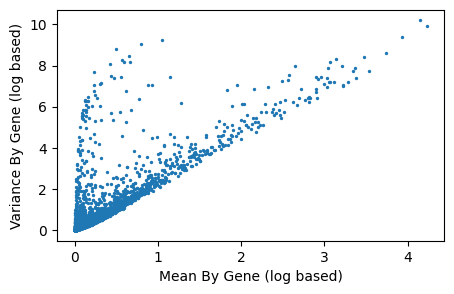

In [16]:
plt.figure(figsize=(5,3))
plt.scatter(np.log1p(mean_by_Gene.values), np.log1p(var_by_Gene.values), s = 2)
plt.xlabel('Mean By Gene (log based)')
plt.ylabel('Variance By Gene (log based)')
plt.show()

In [17]:
del mean_by_Gene

**<h5>1.4 Data Distribution</h5>**

+ Proportion of each label 

In [18]:
labels = train_df['CellType'].to_numpy().astype('int8')

unique, counts = np.unique(labels, return_counts=True)

In [19]:
pd.DataFrame({
    'labels': unique,
    'ratio': counts * 100 / sum(counts)
})

,labels,ratio
0,1,1.447873
1,2,79.861984
2,3,2.676470
3,4,1.254394
4,5,0.209603
5,6,0.067718
6,7,11.931250
7,8,1.802586
8,9,0.212828
9,10,0.535294


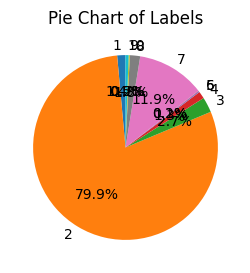

In [20]:
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=[f'{val}' for val in unique], autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Labels')
plt.show()

-> We see Extreme Class Imbalace

Where Cell type 2 dominates all classes at ~ 80%, this can create a lot of biases towards **label 2** in the training process

+ Gene distribution

-> I will pick top 10 most variable genes for visualization

In [21]:
top_10_genes = var_by_Gene.sort_values(ascending=False).head(10)

In [22]:
top_10_var_names = top_10_genes.index.tolist()
high_variable_df = train_df.loc[:, top_10_var_names]

Text(0.5, 0, 'Gene Expression')

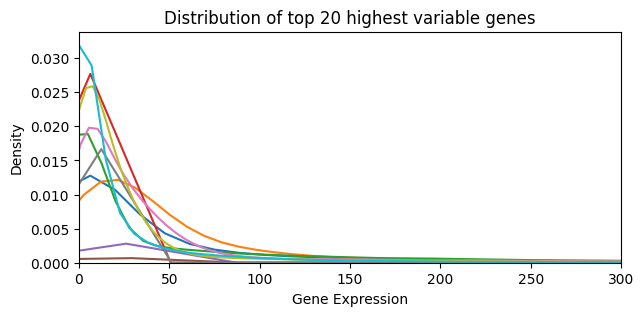

In [23]:
plt.figure(figsize=(7, 3))
for gene in top_10_var_names:
    sns.kdeplot(high_variable_df.loc[:, gene], label = gene)

plt.xlim([0,300])
plt.title('Distribution of top 20 highest variable genes')
plt.xlabel('Gene Expression')

In [24]:
del top_10_genes
del top_10_var_names
del high_variable_df

gc.collect()

3144

**<h5>1.5 Gene activity per cell type</h5>**

In [25]:
x = train_df.groupby('CellType').mean().iloc[:, 1:]

<Axes: ylabel='CellType'>

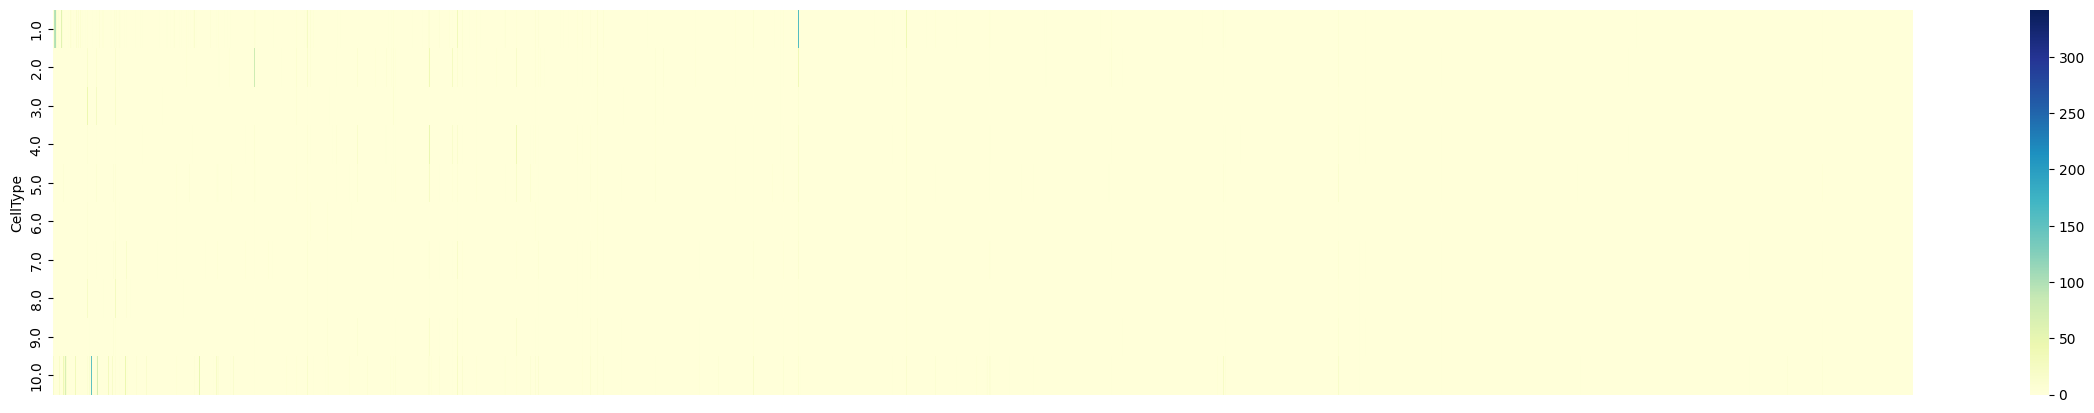

In [26]:
plt.figure(figsize=(30, 5))
sns.heatmap(data=x, cmap="YlGnBu", xticklabels=False, linecolor='gray')

#Definitely, some genes are very active in one specific class ! We will use them as Marker Genes

In [27]:
del x
gc.collect()

5

**<h3> 2. Feature Engineering </h3>**

**<h5>2.1 Stabilize Data</h5>**

**2.1.1 Split Gene Matrix and Label vector**

In [28]:
#train set
train_genes = train_df.iloc[:, 2:]
train_labels = train_df['CellType']

In [29]:
#test set
test_genes = test_df.iloc[:, 1:]

**2.1.2 Remove Gene with low variance**

In [30]:
#Remove Gene with low var on train set
selector = VarianceThreshold(threshold = 0.01)
reduced_train_genes = selector.fit_transform(train_genes)

In [31]:
selected_columns = train_genes.columns[selector.get_support()]
reduced_train_genes = pd.DataFrame(reduced_train_genes, columns=selected_columns)

In [32]:
#Apply the same on test set using selected columns from train
reduced_test_genes = pd.DataFrame(test_genes.loc[:, selected_columns].to_numpy(), columns=selected_columns)

**2.1.3 Log transformation to reduce skewness**

In [33]:
log_reduced_train_genes = np.log1p(reduced_train_genes)
log_reduced_test_genes  = np.log1p(reduced_test_genes)

**<h5>2.2 Dimensionality Reduction using PCA</h5>**

**2.2.1 Prepare data for PCA**

We will be using top 2000 variable genes as input for PCA

In [34]:
k = 2000

top_k_genes = var_by_Gene.sort_values(ascending=False).head(k)

In [35]:
centered_data = log_reduced_train_genes - log_reduced_train_genes.mean()

In [36]:
top_k_names = top_k_genes.index.tolist()

X_top_K = centered_data.loc[:, top_k_names].to_numpy()

**2.2.2 Fit PCA**

In [37]:
pca = PCA(n_components=500)
X_pca = pca.fit_transform(X_top_K)

**2.2.3 Show Cumulative Coverage + Scree Plot**

In [38]:
cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)

In [39]:
pd.DataFrame({
    'PC':np.arange(1, 11, 1),
    'Variance Explained': pca.explained_variance_ratio_[:10],
    'Cumulative Variance Explained': cumulative_ratio[:10]
})

,PC,Variance Explained,Cumulative Variance Explained
0,1,0.288992,0.288992
1,2,0.137180,0.426172
2,3,0.051477,0.477649
3,4,0.020058,0.497707
4,5,0.016031,0.513738
5,6,0.013581,0.527319
6,7,0.010996,0.538315
7,8,0.009673,0.547988
8,9,0.008957,0.556945
9,10,0.006911,0.563856


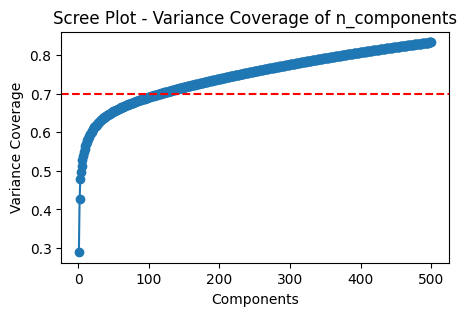

In [40]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(cumulative_ratio) + 1), cumulative_ratio, marker='o')
plt.axhline(y=0.7, color='r', linestyle='--', label='95% variance')
plt.title('Scree Plot - Variance Coverage of n_components')
plt.xlabel('Components')
plt.ylabel('Variance Coverage')
plt.show()

In [41]:
del cumulative_ratio

**2.2.4 PCA dataframe**

+ We would use around 100 Components, it will cover around 70% of the variation

a. Train Set

In [42]:
train_PCA = pd.DataFrame(
    X_pca[:, :100],
    columns=[f'PC{i}' for i in range(1, 101)]
)

b. Test Set

In [43]:
centered_data = log_reduced_test_genes - log_reduced_test_genes.mean()

In [44]:
X_top_K = centered_data.loc[:, top_k_names].to_numpy()

In [45]:
X_pca = pca.transform(X_top_K)

In [46]:
test_PCA = pd.DataFrame(
    X_pca[:, :100],
    columns=[f'PC{i}' for i in range(1, 101)]
)

Clean Data

In [47]:
del pca
del X_top_K
del X_pca
del centered_data
gc.collect()

3156

**<h5>2.3. Marker Genes</h5>**

A gene can be more active in one cell type than in another (shown in EDA), we can use that fact to create more **supportive features**

**2.3.1 Heatmap to support idea**

<Axes: title={'center': 'Gene Intensity per Cell Class - Train data'}, ylabel='CellType'>

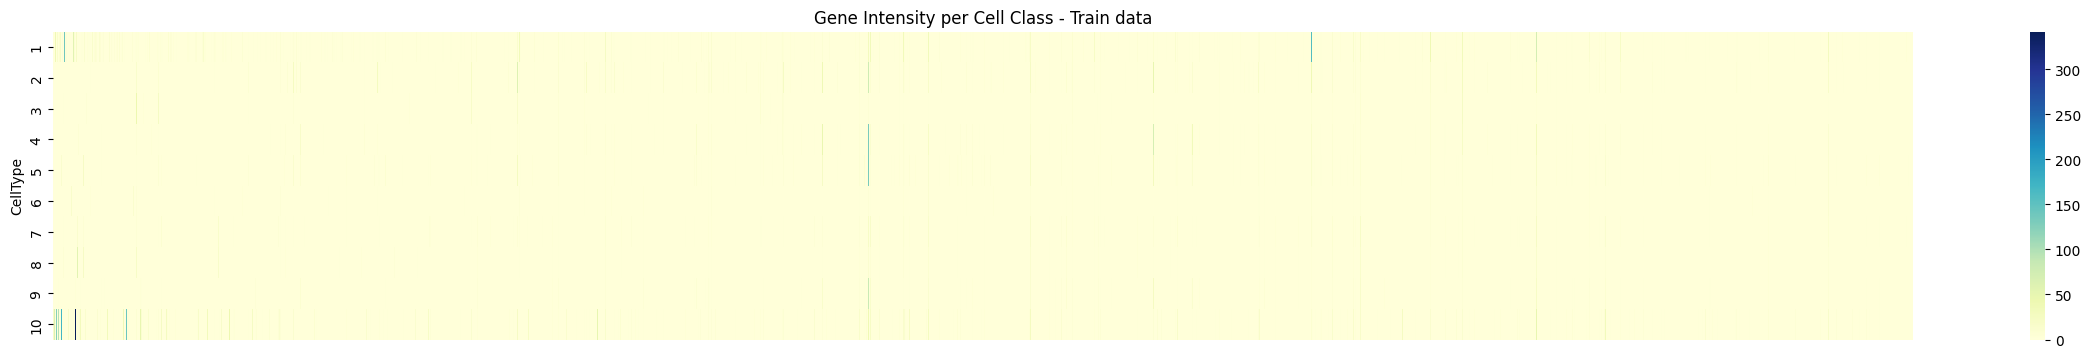

In [48]:
x = pd.concat([pd.DataFrame({'CellType': labels}), reduced_train_genes], axis=1).groupby('CellType').mean().iloc[:, 1:]
plt.figure(figsize=(30, 4))
plt.title('Gene Intensity per Cell Class - Train data')
sns.heatmap(data=x, cmap="YlGnBu", xticklabels=False, linecolor='gray')

**2.3.2 Log Fold Change**

Constrains:

1. Log FC >= 1
2. detect_diff > (80-20) = 0.6

<i>Overall</i>: Score >= 0.4 (Very strict)

In [49]:
def find_marker_genes(data, labels, cell_type, threshold, k, epsilon=1e-6):

    '''
    This function returns top k marker genes ranked by Harmonized Score
    '''

    current_label = data[labels == cell_type]
    other_labels = data[labels != cell_type]

    in_means = current_label.mean() + epsilon
    out_means = other_labels.mean() + epsilon

    log_FC = np.log2(in_means / out_means)

    in_detect = (current_label > 0).sum() / len(current_label)
    out_detect = (other_labels > 0).sum() / len(other_labels)

    detect_diff = in_detect - out_detect

    #harmonized score
    score = (2 * log_FC * detect_diff) / (log_FC + detect_diff)

    score = score[score >= threshold]

    score = score.sort_values(ascending=False).head(k)

    return score.index.tolist()

In [50]:
all_markers = set()
unique_markers = {}

for cell_type in np.unique(labels):
    found_markers = find_marker_genes(reduced_train_genes, labels, cell_type, 0.5, 10)

    all_markers.update(found_markers)

    unique_markers[cell_type] = [marker for marker in found_markers if (marker in all_markers)]

all_markers = list(all_markers)

In [51]:
#For each cell type we do have around 10 distinct Marker Genes
len(all_markers)

97

**2.3.3 We want to visualize how Marker Genes behave**

a. Trainset marker genes

In [52]:
train_marker_gene = reduced_train_genes.loc[:, list(all_markers)]

<Axes: title={'center': 'Marker Gene Intensity per Cell Class - Train data'}, ylabel='CellType'>

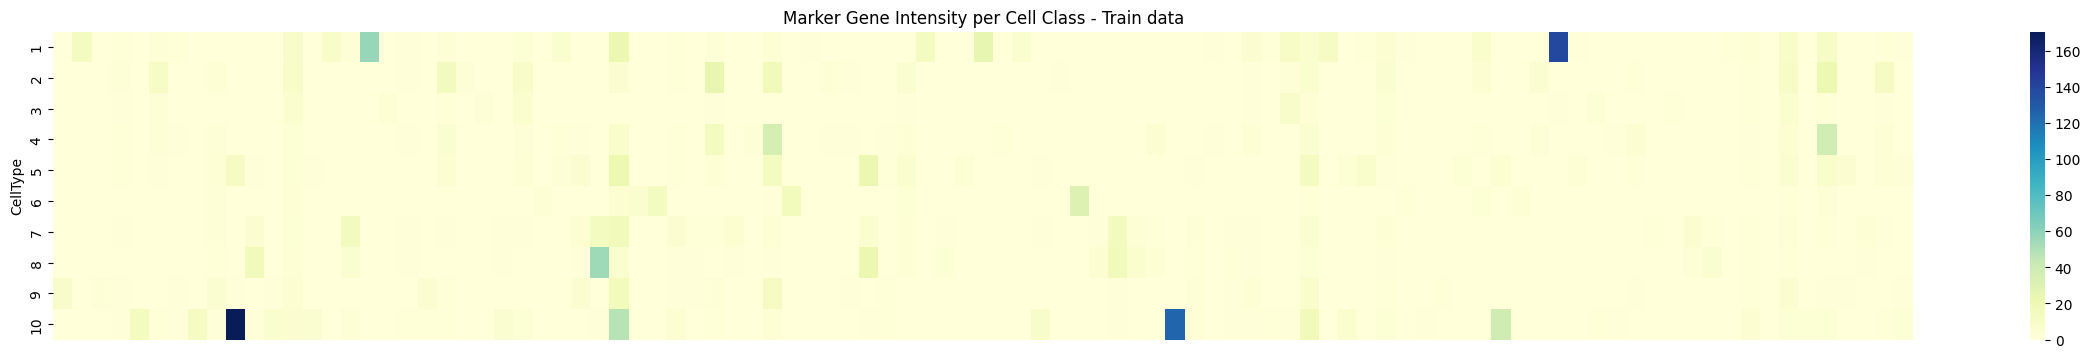

In [53]:
x = pd.concat([pd.DataFrame({'CellType': labels}), train_marker_gene], axis=1).groupby('CellType').mean()
plt.figure(figsize=(30, 4))
plt.title('Marker Gene Intensity per Cell Class - Train data')
sns.heatmap(data=x, cmap="YlGnBu", xticklabels=False, linecolor='gray')

b. Testset marker genes

In [54]:
test_marker_gene = reduced_test_genes.loc[:, list(all_markers)]

**2.3.4 Final Dataset**

Marker Genes are perfect to be the features to train, but using only them is not enough.

The reason is, data is highly imbalance, it's marker gene in the training dataset. But <u>we are not sure</u> if they represent the actual markers in **the underlying distribution**

-> Thus, we combine it with the PCA set, which currenly has no biases towards any label.

a. Trainset

In [168]:
train_log_markers = np.log1p(train_marker_gene)

In [171]:
X_train = pd.concat([train_log_markers, train_PCA], axis = 1)

In [172]:
X_train.head(3)

,MS4A1,KRT8,BANK1,WSB1,FKBP11,SERPINA1,BASP1,IGLL5,CD37,JCHAIN,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,0.0,0.0,0.0,0.693147,0.0,1.098612,0.0,0.0,0.0,0.0,...,-0.217232,0.279965,0.127037,0.047886,0.787094,0.153304,-0.124496,-0.251047,0.444177,-0.335893
1,0.0,0.0,0.0,0.693147,0.0,1.791759,0.0,0.0,0.0,0.0,...,-0.038383,-0.129455,-0.158835,-0.367436,0.197329,0.342992,-0.146266,0.532877,-0.820117,-0.438255
2,0.0,0.0,0.0,0.693147,0.0,1.609438,0.0,0.0,0.0,0.0,...,0.077457,0.091959,0.318095,0.221591,-0.250459,0.357587,0.231073,-0.148886,-0.302011,-0.735163


b. Testset

In [58]:
test_log_markers = np.log1p(test_marker_gene)

In [59]:
X_test = pd.concat([test_log_markers, test_PCA], axis = 1)

In [60]:
X_test.head(3)

,MS4A1,KRT8,BANK1,WSB1,FKBP11,SERPINA1,BASP1,IGLL5,CD37,JCHAIN,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,0.0,0.0,0.0,0.000000,0.0,1.945910,0.0,0.0,1.098612,0.0,...,-0.430992,0.653174,-0.500288,-0.275026,-0.944144,0.146941,0.112798,-0.077805,-0.027322,0.260344
1,0.0,0.0,0.0,0.693147,0.0,1.791759,0.0,0.0,1.098612,0.0,...,0.145651,1.077788,0.168156,0.662105,-0.535711,0.479748,1.201142,-0.398260,0.394861,0.169002
2,0.0,0.0,0.0,0.693147,0.0,1.791759,0.0,0.0,1.945910,0.0,...,-1.492101,0.443004,-0.215529,-0.386997,-0.332076,0.373426,0.348959,0.883221,-0.273691,0.268475


In [61]:
del train_log_markers
del test_log_markers

gc.collect()

21

**<h3>3. Experimental Design</h3>**

We are running multiple Machine Learning models and benchmark them to find the best of all.


For each model:
+ We are running 30 simulations

+ -> For each simulation, we will have 5 Fold Cross Validation (We fit on 80% of data and 20% for validation) 

**<h5>3.1 Training Dataset preparation</h5>**

a. X_train

In [62]:
X_train_numpy = X_train.to_numpy()

In [63]:
X_train_numpy.shape

(31011, 197)

b. y_train

In [64]:
y_train = labels

In [65]:
y_train.shape

(31011,)

**<h5>3.2 Design a simulation matrix</h5>**

+ An N_simulations x M_samples matrix of Indices (each simulation contains 5 Folds, where each is a stratified collection of samples)

In [66]:
from sklearn.model_selection import StratifiedKFold

In [67]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [68]:
max_n_sim = 30

In [69]:
#We design this CV matrix for all models
simulations = []

for sim in range(max_n_sim):
    folds = []
    for train_idx, val_idx in skf.split(X_train_numpy, y_train):
        folds.append((train_idx, val_idx))
    simulations.append(folds)

del folds

**<h3>4. Cross Validation</h3>**

In [70]:
#import libraries
from sklearn.metrics import precision_score, recall_score, f1_score

**<h5>4.1 CV function</h5>**

The CV function:

+ runs n 5-fold simulations and extract precision, recall and F1-score
+ For each metric, it'll calculate the 95% Confidence Interval using t-stats.

In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
from tqdm import tqdm

In [73]:
from sklearn.metrics import precision_recall_fscore_support

**simulation_score guide:**

hyperparameter * simulation_id * (cell_type * 3 metrics) 

In [74]:
def cross_validation():

    def decorator(func):
        
        def wrapper(self, X, y, n_sim, hyper_param_vals):
            #This acts as the run_cv function

            hyper_param_count = len(hyper_param_vals)

            simulation_score = np.repeat(0.0, 10 * n_sim * 3 * hyper_param_count) \
                                            .reshape(-1, n_sim, 10, 3) #precision, recall and F1_score tensor
            
            for id in tqdm( range(hyper_param_count), desc=f"Running CV"):

                #Model prep (call out)########################

                self.prepare_model(hyper_param_vals[id])

                ############################################

                for sim_id in range(n_sim):
                    precision = 0.0
                    recall = 0.0
                    f1 = 0.0

                    for cv_id in range(5):

                        train_indices = simulations[sim_id][cv_id][0]
                        test_indices = simulations[sim_id][cv_id][1]

                        #Prepare Data for fit and test
                        X_train = X[train_indices,:]
                        y_train = y[train_indices]

                        X_test = X[test_indices,:]
                        y_test = y[test_indices]

                        #fitting (call out)
                        self.fit(X_train, y_train)

                        #make predictions (call out)
                        y_pred = self.predict(X_test)

                        #Calulate Metrics for each class

                        precision, recall, f1, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, zero_division=0)


                        for cell_id, (p, r, f) in enumerate(zip(precision, recall, f1)):
                            simulation_score[id, sim_id, cell_id, 0] += (p / 5)
                            simulation_score[id, sim_id, cell_id, 1] += (r / 5)
                            simulation_score[id, sim_id, cell_id, 2] += (f / 5)


            print("Done!")
            return simulation_score
        
        return wrapper
        
    return decorator

**<h5>4.2 Confidence Interval</h5>**

In [75]:
from scipy.stats import t

In [76]:
def confidence_interval(score):

    #Receives 3D array
    t_crit = t.ppf(0.975, df=len(score)-1)
    mean = np.mean(score, axis=0)
    stderr = np.std(score, axis=0) / np.sqrt(len(score))
    rad = stderr * t_crit

    metrics = ["Precision", "Recall", "F1"]

    ci_df = pd.DataFrame(columns=metrics, index=range(10))

    for cell_id in range(10):

        for metric_id in range(3):

            value = f'{mean[cell_id, metric_id]:.2f} ± {rad[cell_id, metric_id]:.3f}'

            ci_df.loc[cell_id, metrics[metric_id]] = value

    return ci_df

**<h5>4.3 Model Benchmarkings</h5>**

**4.3.1 K-nearest Neighbours**

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
class knn_model:

    def prepare_model(self, hyperparam):
        self.model = KNeighborsClassifier(n_neighbors=hyperparam)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    @cross_validation()
    def run_cv_model(self, X, y, n_sim, hyper_param_vals):
        pass

In [79]:
k_values = [3, 5, 10]

In [80]:
knn = knn_model()
score = knn.run_cv_model(X_train_numpy, y_train, n_sim = 30, hyper_param_vals=k_values)

Running CV: 100%|██████████| 3/3 [01:52<00:00, 37.47s/it]

Done!


In [81]:
#Confidence Interval for k=3
confidence_interval(score[0])

,Precision,Recall,F1
0,0.97 ± 0.002,0.95 ± 0.001,0.96 ± 0.001
1,0.98 ± 0.000,0.99 ± 0.000,0.99 ± 0.000
2,0.82 ± 0.003,0.72 ± 0.002,0.77 ± 0.002
3,0.83 ± 0.004,0.63 ± 0.002,0.71 ± 0.002
4,0.97 ± 0.005,0.80 ± 0.004,0.87 ± 0.003
5,0.91 ± 0.015,0.73 ± 0.014,0.79 ± 0.010
6,0.95 ± 0.000,0.96 ± 0.001,0.95 ± 0.000
7,0.88 ± 0.003,0.75 ± 0.003,0.81 ± 0.002
8,0.92 ± 0.005,0.83 ± 0.004,0.87 ± 0.004
9,0.99 ± 0.000,0.88 ± 0.001,0.93 ± 0.001


**4.3.2 Random Forest Classifier**

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
class rf_model:

    def prepare_model(self, hyperparam):
        self.model = RandomForestClassifier(n_estimators=hyperparam,
                                            max_depth=20, 
                                            random_state=42)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    @cross_validation()
    def run_cv_model(self, X, y, n_sim, hyper_param_vals):
        pass

In [84]:
n_estimator_value = [100, 200]

In [85]:
rf = rf_model()
score = rf.run_cv_model(X_train_numpy, y_train, n_sim = 5, hyper_param_vals=n_estimator_value)

Running CV: 100%|██████████| 2/2 [25:17<00:00, 758.87s/it]

Done!


In [86]:
#Confidence Interval for n_est = 100
confidence_interval(score[0])

,Precision,Recall,F1
0,0.99 ± 0.002,0.91 ± 0.006,0.95 ± 0.003
1,0.97 ± 0.000,1.00 ± 0.000,0.98 ± 0.000
2,0.97 ± 0.004,0.52 ± 0.007,0.67 ± 0.006
3,0.93 ± 0.011,0.44 ± 0.009,0.59 ± 0.008
4,0.99 ± 0.010,0.78 ± 0.000,0.87 ± 0.005
5,0.87 ± 0.092,0.41 ± 0.046,0.53 ± 0.056
6,0.93 ± 0.001,0.96 ± 0.001,0.95 ± 0.001
7,0.95 ± 0.003,0.70 ± 0.004,0.80 ± 0.003
8,0.98 ± 0.002,0.79 ± 0.012,0.87 ± 0.007
9,0.99 ± 0.000,0.85 ± 0.008,0.91 ± 0.004


In [87]:
#Confidence Interval for n_est = 200
confidence_interval(score[1])

,Precision,Recall,F1
0,0.99 ± 0.003,0.91 ± 0.005,0.95 ± 0.002
1,0.97 ± 0.000,1.00 ± 0.000,0.98 ± 0.000
2,0.97 ± 0.002,0.52 ± 0.008,0.67 ± 0.007
3,0.94 ± 0.009,0.44 ± 0.008,0.60 ± 0.010
4,1.00 ± 0.009,0.78 ± 0.008,0.87 ± 0.007
5,0.84 ± 0.112,0.44 ± 0.065,0.56 ± 0.080
6,0.94 ± 0.001,0.96 ± 0.001,0.95 ± 0.001
7,0.95 ± 0.004,0.70 ± 0.007,0.81 ± 0.006
8,0.98 ± 0.002,0.79 ± 0.021,0.87 ± 0.014
9,0.99 ± 0.000,0.85 ± 0.008,0.91 ± 0.005


**4.3.3 Support Vector Machines**

In [88]:
from sklearn.svm import SVC

In [89]:
class svm_model:

    def prepare_model(self, hyperparam):
        self.model = SVC(kernel='linear', C=hyperparam, gamma='scale') 

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    @cross_validation()
    def run_cv_model(self, X, y, n_sim, hyper_param_vals):
        pass

In [90]:
reg_vals = [0.1, 1]

In [91]:
svm = svm_model()
score = svm.run_cv_model(X_train_numpy, y_train, n_sim = 5, hyper_param_vals=reg_vals)

Running CV: 100%|██████████| 2/2 [03:50<00:00, 115.03s/it]

Done!


In [92]:
confidence_interval(score[0])

,Precision,Recall,F1
0,0.98 ± 0.002,0.96 ± 0.005,0.97 ± 0.003
1,0.98 ± 0.000,0.99 ± 0.000,0.99 ± 0.000
2,0.88 ± 0.010,0.77 ± 0.010,0.82 ± 0.009
3,0.88 ± 0.012,0.63 ± 0.008,0.73 ± 0.007
4,0.97 ± 0.010,0.88 ± 0.027,0.92 ± 0.014
5,0.90 ± 0.043,0.80 ± 0.028,0.83 ± 0.015
6,0.96 ± 0.001,0.97 ± 0.001,0.96 ± 0.001
7,0.89 ± 0.005,0.84 ± 0.005,0.86 ± 0.004
8,0.95 ± 0.024,0.89 ± 0.014,0.91 ± 0.012
9,0.98 ± 0.010,0.87 ± 0.008,0.92 ± 0.005


**4.3.4 XG boost**

In [94]:
from xgboost import XGBClassifier

In [95]:
class xgb_model:

    def prepare_model(self, hyperparam):
        self.model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # no warning

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    @cross_validation()
    def run_cv_model(self, X, y, n_sim, hyper_param_vals):
        pass

In [96]:
xgb = xgb_model()
score = xgb.run_cv_model(X_train_numpy, y_train - 1, n_sim = 5, hyper_param_vals=[0])

Running CV: 100%|██████████| 1/1 [01:00<00:00, 60.75s/it]

Done!


In [97]:
confidence_interval(score[0])

,Precision,Recall,F1
0,0.98 ± 0.002,0.95 ± 0.004,0.97 ± 0.003
1,0.98 ± 0.000,0.99 ± 0.000,0.99 ± 0.000
2,0.92 ± 0.004,0.74 ± 0.011,0.82 ± 0.006
3,0.91 ± 0.015,0.61 ± 0.008,0.73 ± 0.008
4,0.99 ± 0.011,0.84 ± 0.019,0.90 ± 0.012
5,0.82 ± 0.010,0.88 ± 0.029,0.84 ± 0.018
6,0.96 ± 0.002,0.97 ± 0.001,0.96 ± 0.001
7,0.91 ± 0.010,0.82 ± 0.009,0.86 ± 0.006
8,0.97 ± 0.008,0.88 ± 0.024,0.92 ± 0.013
9,0.99 ± 0.006,0.89 ± 0.007,0.93 ± 0.004


**<h4>4.3.5 Ensembled Model (no CV)</h4>**

I've observed that SVMs and XGBoost work really well. Now I try to combine them.
 

In [98]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_numpy, y_train, stratify=y_train, test_size=0.4, random_state=42)

**4.3.5.1 Validate performance of SVMs**

In [132]:
svm = SVC(kernel='linear', C=0.1, gamma='scale', probability=True) 

In [133]:
svm.fit(X_train_split, y_train_split)

SVC(C=0.1, kernel='linear', probability=True)

In [134]:
svm_pred_prob = svm.predict_proba(X_val_split)

In [135]:
svm_pred = np.argmax(svm_pred_prob, axis=1) + 1

In [136]:
print(classification_report(y_pred=svm_pred, y_true=y_val_split))

              precision    recall  f1-score   support

           1       0.99      0.91      0.95       180
           2       0.98      0.99      0.99      9907
           3       0.89      0.72      0.79       332
           4       0.89      0.60      0.72       156
           5       1.00      0.85      0.92        26
           6       1.00      0.62      0.77         8
           7       0.95      0.97      0.96      1480
           8       0.87      0.83      0.85       224
           9       1.00      0.85      0.92        26
          10       1.00      0.88      0.94        66

    accuracy                           0.97     12405
   macro avg       0.96      0.82      0.88     12405
weighted avg       0.97      0.97      0.97     12405



**4.3.5.2 Validate performance of XGBoost**

In [137]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [138]:
xgb.fit(X_train_split, y_train_split - 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [139]:
xgb_pred_prob = xgb.predict_proba(X_val_split)

In [140]:
xgb_pred = np.argmax(xgb_pred_prob, axis=1) + 1

In [141]:
print(classification_report(y_pred=xgb_pred, y_true=y_val_split))

              precision    recall  f1-score   support

           1       0.99      0.96      0.97       180
           2       0.98      1.00      0.99      9907
           3       0.92      0.68      0.78       332
           4       0.92      0.58      0.71       156
           5       0.95      0.81      0.88        26
           6       0.86      0.75      0.80         8
           7       0.96      0.97      0.96      1480
           8       0.90      0.83      0.87       224
           9       1.00      0.77      0.87        26
          10       0.98      0.89      0.94        66

    accuracy                           0.97     12405
   macro avg       0.95      0.82      0.88     12405
weighted avg       0.97      0.97      0.97     12405



**ENSEMBLE !**

In [146]:
svm_weight = 0.6
xgb_weight = 0.4

In [147]:
ensembled_prob = svm_weight * svm_pred_prob + xgb_weight * xgb_pred_prob

In [148]:
ensembled_pred = np.argmax(ensembled_prob, axis=1) + 1

In [150]:
print(classification_report(y_pred=ensembled_pred, y_true=y_val_split))

              precision    recall  f1-score   support

           1       0.98      0.93      0.96       180
           2       0.98      1.00      0.99      9907
           3       0.92      0.69      0.79       332
           4       0.93      0.62      0.74       156
           5       0.95      0.77      0.85        26
           6       0.83      0.62      0.71         8
           7       0.96      0.97      0.97      1480
           8       0.91      0.85      0.88       224
           9       1.00      0.85      0.92        26
          10       1.00      0.89      0.94        66

    accuracy                           0.98     12405
   macro avg       0.95      0.82      0.87     12405
weighted avg       0.97      0.98      0.97     12405



**<h4>4.3.6 Neural Networks</h4>**

In [191]:
from tensorflow.keras import losses, optimizers, layers, Sequential

In [192]:
X_train_numpy.shape

(31011, 197)

In [300]:
model = Sequential([
    layers.InputLayer(shape=(197, )),
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.3),


    layers.Dense(10, activation='softmax')
])

In [301]:
loss = losses.SparseCategoricalCrossentropy(from_logits=False)
opt = optimizers.Adam(learning_rate=1e-3)
model.compile(loss = loss,
              optimizer = opt)

In [304]:
model.fit(X_train_split, y_train_split-1, epochs=10, batch_size=32)

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0609
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0581
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0582
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0586
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0540
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0571
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0517
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0452
Epoch 9/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0441
Epoch 10/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0490


In [305]:
nn_pred_prob = model.predict(X_val_split)
nn_pred = np.argmax(nn_pred_prob, axis=1) + 1
print(classification_report(y_pred=nn_pred, y_true=y_val_split))

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           1       0.98      0.96      0.97       180
           2       0.99      0.99      0.99      9907
           3       0.83      0.80      0.82       332
           4       0.89      0.65      0.75       156
           5       1.00      0.88      0.94        26
           6       1.00      0.75      0.86         8
           7       0.96      0.97      0.97      1480
           8       0.91      0.88      0.89       224
           9       0.96      0.88      0.92        26
          10       0.97      0.89      0.93        66

    accuracy                           0.98     12405
   macro avg       0.95      0.87      0.90     12405
weighted avg       0.98      0.98      0.98     12405



**<h3>5. Conclusion</h3>**

We have benchmarked 4 models: KNN, RF, SVMs, XGBoost and a simple Feed-forward NN

Overall, Neural Network performs really well with very high metrics across the classes

In [306]:
X_test_numpy = X_test.to_numpy()

In [307]:
test_prob = model.predict(X_test_numpy)
test_pred = np.argmax(test_prob, axis=1) + 1

632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [308]:
vals, count = np.unique(test_pred, return_counts=True)

In [309]:
pd.DataFrame({
    'val':vals,
    'ratio': count / sum(count)
})

,val,ratio
0,1,0.018649
1,2,0.899238
2,3,0.001286
3,4,0.019836
4,5,0.001830
5,6,0.000049
6,7,0.047636
7,8,0.008657
8,9,0.001830
9,10,0.000989
